***
## notebook config

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        5.5G         19G        1.1M        697M         19G
Swap:            0B          0B          0B


In [5]:
!pip install --upgrade category_encoders > /dev/null 2>&1
!pip install --upgrade lightgbm > /dev/null 2>&1
!pip install --upgrade tsforest > /dev/null 2>&1

***

In [6]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

***
## data preparation

In [8]:
!kaggle datasets download -d mavillan/meli-2021 --force --unzip

 94% 50.0M/53.3M [00:00<00:00, 51.5MB/s]
100% 53.3M/53.3M [00:00<00:00, 77.7MB/s]


In [9]:
dataset = pd.read_parquet("./dataset.parquet")
dataset.rename({"date":"ds", "sold_quantity":"y"}, axis=1, inplace=True)
dataset

,ds,sku,y,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id
0,2021-02-01,0,0,172.789993,REA,classic,cross_docking,free_shipping,0.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
1,2021-02-02,0,0,172.789993,REA,classic,cross_docking,free_shipping,0.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
2,2021-02-03,0,0,179.990005,REA,classic,cross_docking,free_shipping,872.650024,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
3,2021-02-04,0,0,179.990005,REA,classic,cross_docking,free_shipping,1440.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
4,2021-02-05,0,0,179.990005,REA,classic,cross_docking,free_shipping,1440.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994039,2021-03-27,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
38994040,2021-03-28,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
38994041,2021-03-29,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
38994042,2021-03-30,660915,0,99.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None


In [10]:
dataset["fold"] = dataset.ds.dt.month - 2

categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": ("y", ce.CatBoostEncoder, None),
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

In [11]:
dataset.loc[:,categorical_features.keys()].nunique()

sku                       660916
currency                       4
listing_type                   2
shipping_logistic_type         3
shipping_payment               2
item_domain_id              8408
item_id                   517896
site_id                        3
product_id                 15863
product_family_id          29600
dtype: int64

In [12]:
dataset.groupby("site_id")["sku"].nunique()

site_id
MLA     58670
MLB    336334
MLM    265912
Name: sku, dtype: int64

***
## model training

In [13]:
# model configuration
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'l1',
    'num_iterations':1000,
    'max_bin': 127,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**9-1,
    'min_data_in_leaf': 2**9-1,
    'learning_rate': 0.05,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'boost_from_average': False,
    'force_col_wise': True,
}

time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]

In [14]:
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
}

---------------------------------------------------------------------------
Training model for fold: 1
Mem. usage decreased to 1910.68 Mb (42.8% reduction)
Mem. usage decreased to 1406.83 Mb (52.9% reduction)
Elapsed time for processing features: 4.875044858455658 min.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 18505648, number of used features: 17
Training until validation scores don't improve for 30 rounds
[50]	valid_0's l1: 0.935419
[100]	valid_0's l1: 0.917309
[150]	valid_0's l1: 0.914455
[200]	valid_0's l1: 0.913371
[250]	valid_0's l1: 0.912782
[300]	valid_0's l1: 0.912297
[350]	valid_0's l1: 0.911954
[400]	valid_0's l1: 0.911513
[450]	valid_0's l1: 0.911144
Early stopping, best iteration is:
[466]	valid_0's l1: 0.910934
Elapsed time for training the model: 23.548625151316326 min.


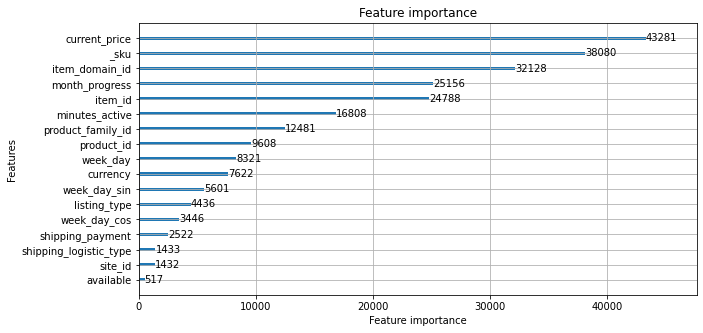

---------------------------------------------------------------------------
Training model for fold: 0


In [ ]:
lgbm_models = list()

for fold in [1,0]:
    print("-"*75)
    print(f"Training model for fold: {fold}")
    model = LightGBMForecaster(**model_kwargs)
    valid_idx = dataset.query("fold == @fold").index

    tic = time.time()
    model.prepare_features(dataset, valid_idx);
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit(fit_kwargs={"verbose_eval":50,})
    lgbm_models.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    lgb.plot_importance(model.model.model, figsize=(10,5))
    plt.show()


***